# CSTRs

These exercises cover the solution of steady state and transient CSTR problems. It also outlines some good coding practices related to the use of global variable assignments as opposed to local variable assignments. The example problems presented here have already been solved in prior notebooks. We are using them as test cases to explore different ways of writing code. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

(example-problem-01)=
## Example Problem 01

```{note}
This exact problem was solved in [Example Problem 02 from Notebook 21](https://jqbond.github.io/CEN587/Notebooks/587-N21.html#example-problem-02). We will present the solution of the steady state problem again as a base case, and then we will extend consideration of reactor startup, which is a non-steady state CSTR design problem. 
```

Consider the following liquid-phase, irreversible, homogeneous reaction that is occuring in a perfectly-mixed CSTR

$$A + B \longrightarrow C$$

This reaction is first order in A and first order in B. You may assume that the liquid phase has a constant density. Additional data are given below:

\begin{align*}
    k &= 25.3 \ \mathrm{L \ mol^{-1} \ h^{-1}} \\
    Q_f &= 10 \ \mathrm{L \ h^{-1}} \\
    F_{Af} &= 10 \ \mathrm{mol \ h^{-1}} \\
    F_{Bf} &= 10 \ \mathrm{mol \ h^{-1}} \\
\end{align*}

What fractional conversion of species $A$ is achieved in 1.24 L CSTR?

**Answer**: $X_A = 0.573$

### Analytical Solution to Example Problem 01

We are asked to relate the fractional conversion of $A$ to reactor size, which prompts us to write a balance on $A$:

$$0 = F_{A,f} - F_A + R_AV$$

The feed molar flowrate of $A$, $F_{A,f}$ is given in the problem statement $(F_{A,f} = 10 \ \mathrm{mol h^{-1}})$, as is the reactor volume $(V = 1.24\mathrm{L})$. We also see an intensive production rate, $R_A$, which we define as usual:

$$R_A = \sum_{i = 1}^{N_R} \nu_{i,A} \, r_i$$

For this single reaction:

$$R_A = -r$$

We know the rate expression:

$$r = kC_AC_B$$

So this gives

$$R_A = -kC_AC_B$$

Which we can substitute into the material balance:

$$0 = F_{A,f} - F_A - kC_AC_BV$$

At the moment, we have 3 unknowns in this equation: $F_A$, $C_A$, $C_B$. If we want to solve this by hand, we'll need to express $F_A$, $C_A$, $C_B$ in terms of a single unknown.  I'll choose to work with fractional conversion of $A$ here.  Completing a mole table, we find:

\begin{align*}
    F_A &= F_{A,f}(1 - X_A) \\
    F_B &= F_{B,f} - F_{A,f}X_A \\
\end{align*}

But: we see in the problem statement, that for this problem, $F_{A,f} = F_{B,F}$.  So, in this special case:

\begin{align*}
    F_A &= F_{A,f}(1 - X_A) \\
    F_B &= F_{A,f}(1 - X_A) \\
\end{align*}

Because this is a flow reactor operating at steady state, it is convenient to concentrations in terms of flowrates. We further know that for a constant density process in a flow reactor, $Q = Q_f$:

\begin{align*}
    C_A &= F_A/Q_f \\
    C_B &= F_A/Q_f \\
\end{align*}

Substituting everything into the material balance, we get:

$$0 = F_{A,f} - F_{A,f}(1 - X_A) - kF_{A,f}^2(1-X_A)^2\frac{V}{Q_f^2}$$

We can solve this by simplifying, doing some FOIL magic, and using the quadratic formula. Ultimately, we get:

$$0 = X_A^2 + (\alpha - 2)X_A + 1$$

Where $\alpha = -Q_f^2/k/F_{A,f}/V$

If you solve that with the quadratic formula, you'll find two roots at:

$$X_A = 0.573$$

and at

$$X_A = 1.746$$

Mathematically, they are both fine, but physically, we can't have a conversion of more than 100% since it would mean we consume more reactant than we put into the reactor.  So we reject the upper root and conclude that our solution is:

$$X_A = 0.573$$

(example-problem-02)=
## Example Problem 02: What if the CSTR is not at steady state?

Assume the CSTR described in [Example Problem 01](#example-problem-01) initially contains a solvent that is equal in density to the typical reactor contents (it just has no reactants or products in it). The feed stream coming into the CSTR contains species $A$ and $B$ at a concentration of $1.00 \ \mathrm{mol \ L^{-1}}$. The volume of this reactor is $V = 1.24\mathrm{L}$ as before. Additional details are below:

$$A + B \longrightarrow C$$

This reaction is first order in $A$ and first order in $B$. You may assume that the liquid phase always has constant density that is exactly the same as the solvent initially inside of the reactor. You may additionally assume that, because of this, the volumetric flowrate into and out of the reactor are always equal.

\begin{align*}
    k &= 25.3 \ \mathrm{L \ mol^{-1} \ h^{-1}} \\
    Q_f &= 10 \ \mathrm{L \ h^{-1}} \\
\end{align*}

***After startup, approximately how long will it take for this reactor to reach steady state?*** 

### Solution to Example Problem 02

In this case, the left hand side of the material balance, ${dN_j/dt} \neq 0$. Whereas the steady state CSTR involves solving algebraic equations, the transient CSTR involves solving ODEs (it is an initial value problem).

We start by writing a balance on species A:

$$\frac{dN_A}{dt} = F_{Af} - F_A + R_AV$$

We note here that our independent variable is time and our state dependent variable is $N_A$. This means that if we hope to solve this ODE analytically, everything on the right hand side needs to be a function of $(t, N_A)$.  We start making definitions. Because density and volume in this system are constant, $Q = Q_f$, and we can therefore define the exit molar flowrate of A as:

$$F_A = C_AQ_f$$

We know $Q_f$, but we need to define $C_A$ in terms of our state variables. This is relatively straightforward for a constant volume reactor:

$$C_A = \frac{N_A}{V}$$

```{tip}
We sometimes get used to the idea that, in flow reactors, we should define species concentrations as $C_j = F_j/Q$. This is, of course, always allowed, but it is only really convenient in reactors at steady state. When we operate away from steady state (e.g., in a CSTR), we have a differential equation that describes how the number of moles of species $j$, $N_j$, changes as a function of time, i.e., $N_j$ is the natural state dependent variable in this ODE. It is usually easiest for us to then try to define things in terms of that state dependent variable since defining them in any other way will be less convenient and lead to more work for us as we proceed through the problem solution.
```

Now we define the intensive production rate of A:

$$R_A = -r$$

And the rate of reaction is given by:

$$r = kC_AC_B$$

This requires a definition of $C_B$:

$$C_B = \frac{N_B}{V}$$

Now we have to make a choice about how to deal with $N_B$, which is a second state dependent variable in that it is definitely changing as a function of time. We could try to express $N_A$ and $N_B$ in terms of an extent variable like reaction extent or fractional conversion; however, it becomes unclear how one should relate $N_A$ and $N_B$ to an extent variable in a transient CSTR where the change in the number of moles of species in the tank a function of both extent *and* time because it also depends on the balance between species inflow and species outflow. In this case, the better strategy is probably to write a separate balance on species $B$. This will result in two coupled ODEs written in terms of one independent variable, $t$, and two state dependent variables, $N_A$ and $N_B$. We make sure to define everything on the right hand side of these two ODEs either as constant or as a function of state variables and the independent variable. If we can do this, we can solve this coupled system of ODEs with `solve_ivp()`.

$$\frac{dN_B}{dt} = F_{Bf} - F_B + R_BV$$

Where the following definitions facilitate numerical solution:

$$F_B = C_BQ_f$$

And

$$R_B = -r$$

Finally, we note that, in the initial state of this system, there is no A or B present in the reactor. It is only solvent.  So our starting states are:

\begin{align*}
    N_{A0} = 0.0 \\
    N_{B0} = 0.0
\end{align*}

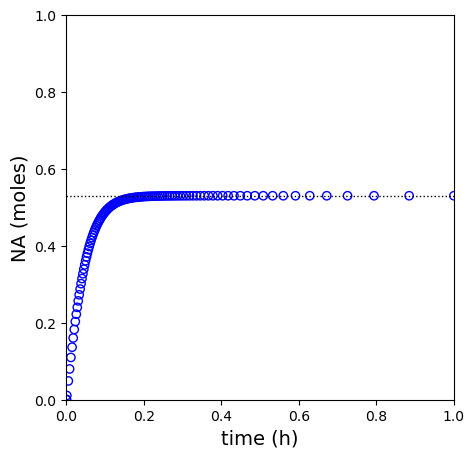

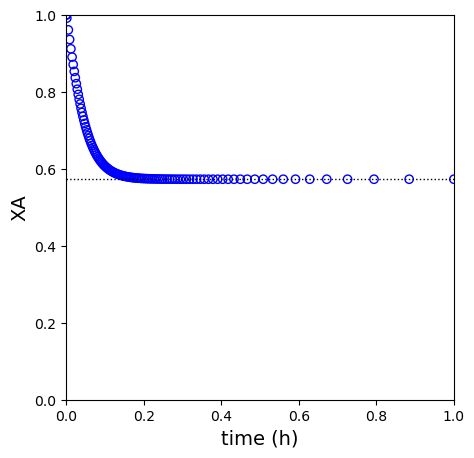

The steady state conversion in this reactor is XA = 0.573


In [2]:
####################################################################################
# Define the ODE system as f(t, [NA, NB]) returning [dNAdt, dNBdt]                 #
####################################################################################

def P02(t,var): 
    NA  = var[0]
    NB  = var[1]
    k   = 25.3 #1/h
    V   = 1.24 #L
    CAf = 1.0 #mol/L
    CBf = 1.0 #mol/L
    Qf  = 10 #L/h  
    FAf = CAf * Qf
    FBf = CBf * Qf

    CA  = NA/V
    CB  = NB/V
    FA  = CA*Qf
    FB  = CB*Qf
    r   = k*CA*CB
    RA  = - r
    RB  = - r
    
    dNAdt = FAf - FA + RA*V
    dNBdt = FBf - FB + RB*V
    return [dNAdt, dNBdt]

##############################################################################
# Define constant parameters from problem statement                          #
##############################################################################

V   = 1.24 #L
CAf = 1.0 #mol/L
CBf = 1.0 #mol/L
Qf  = 10 #L/h  
FAf = CAf*Qf
FBf = CBf*Qf
NSS = 0.530 #steady state number of moles of A in tank
XSS = 0.573 #steady state fractional conversion of A
FSS = FAf*(1 - XSS)

##############################################################################
# Define parametrs for solve_ivp(); initial state, integration span          #
##############################################################################

N0    = [0.0, 0.0]
tspan = [0, 1]

##############################################################################
# Solve the ODE system using solve_ivp                                       #
##############################################################################

sol_tCSTR = solve_ivp(P02, tspan, N0, atol = 1e-10, rtol = 1e-10)

##############################################################################
# Extract significan quantities from solution structure; workup data         #
##############################################################################

tset = sol_tCSTR.t
NA   = sol_tCSTR.y[0,:]
FA   = NA/V*Qf
XA   = (FAf - FA)/FAf

##############################################################################
# Graph solutions; first plot NA vs. time                                    #
##############################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tset, NA, color = 'none', edgecolors = 'blue')
plt.hlines(NSS, 0, tspan[-1], color = 'black', ls = 'dotted', lw = 1.0)
plt.xlim(0, tspan[-1])
plt.xlabel('time (h)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('NA (moles)', fontsize = 14)
plt.show()

######################################################################################################
# Plot XA = (FAf - FA)/FAf vs. time                                                                  # 
# Note that a flow-based XA is meaningless away from steady state                                    #
###################################################################################################### 

plt.figure(figsize = (5, 5))
plt.scatter(tset, XA, color = 'none', edgecolors = 'blue')
plt.hlines(XSS, 0, tspan[-1], color = 'black', ls = 'dotted', lw = 1.0)
plt.xlim(0, tspan[-1])
plt.xlabel('time (h)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('XA', fontsize = 14)
plt.show()


######################################################################################################
# Print steady state conversion obtained by integration to t --> ∞                                   #
######################################################################################################

print(f'The steady state conversion in this reactor is XA = {XA[-1]:0.3f}')

## Writing cleaner code

There is nothing fundamentally wrong with the code in the sections above. It solves the problem correctly.  However, if you study it carefully, you may notice that we defined identical variables in multiple different places in the workspace, inside of and outside of functions, etc. Things like $V$, $C_{Af}$, $C_{Bf}$ are all defined multiple places. When we do this in the "global workspace," i.e., in sections of code outside of a function, loop, or similar construct, we are writing a global variable (which is accessible everywhere in our code) and then redefining it elsewhere in the code. Generally, this is bad practice because it makes it difficult to change and adapt the code to apply to new situations. For example, if we are now asked to consider the impact of a change to the reactor in [Example Problem 02](#example-problem-02)--say an increase or decrease in the feed volumetric flowrate, $Q_f$, we would now need to hunt around and make sure that we've redefined $Q_f$ correctly everywhere in my code. It doesn't *sound* difficult to do, but as we start writing more complex codes, it can be maddening to track down variable definitions this way.

Usually, it is best to define constants only once. There are various ways you can do this. A common and easy way to do this in Python is to just accept the fact that things in the global Python workspace (things outside of functions, loops, etc.) are global variables by default. This means that, technically, they are accessible everywhere in our codes, including inside of a function or loop. With this i mind, we could get away with the following alternative code.  This will give the exact same result, but the code is cleaner.

```{tip}
Global variables are defined in the top-level workspace and are defined and accessible throughout our code. This contrasts with local variables that are defined and accessible only within the scope of a single function, loop, or similar construct.
```

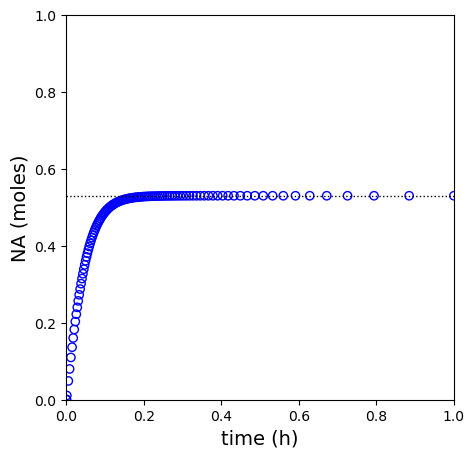

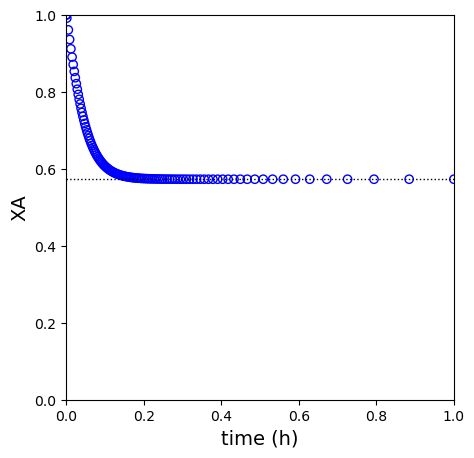

The steady state conversion in this reactor is XA = 0.573


In [3]:
##################################################################
# Global variable definitions - also defined inside of functions #
##################################################################

k   = 25.3 #1/h
V   = 1.24 #L
CAf = 1.0 #mol/L
CBf = 1.0 #mol/L
Qf  = 10 #L/h  
FAf = CAf * Qf
FBf = CBf * Qf

########################################################################
# Function definition - no need to redefine globals inside of function #
########################################################################

def P02a(t, var): 
    NA  = var[0]
    NB  = var[1]

    FAf = CAf * Qf
    FBf = CBf * Qf

    CA  = NA/V
    CB  = NB/V
    FA  = CA*Qf
    FB  = CB*Qf
    r   = k*CA*CB
    RA  = - r
    RB  = - r
    
    dNAdt = FAf - FA + RA*V
    dNBdt = FBf - FB + RB*V
    return [dNAdt, dNBdt]

##########################################################################################
# The next two variables, initial state and integration span, are also globals           #
##########################################################################################

N0 = [0.0, 0.0]
tspan = [0, 1]

##########################################################################################
# Solving the ODE system -- all results and subsequent workup are stored as globals      #
##########################################################################################

sol_tCSTRa = solve_ivp(P02a, tspan, N0, atol = 1e-10, rtol = 1e-10)
tset = sol_tCSTRa.t
NA   = sol_tCSTRa.y[0,:]
FA   = NA/V*Qf
XA   = (FAf - FA)/FAf

##############################################################################
# Graph solutions; first plot NA vs. time                                    #
##############################################################################

plt.figure(figsize = (5, 5))
plt.scatter(tset, NA, color = 'none', edgecolors = 'blue')
plt.hlines(NSS, 0, tspan[-1], color = 'black', ls = 'dotted', lw = 1.0)
plt.xlim(0, tspan[-1])
plt.xlabel('time (h)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('NA (moles)', fontsize = 14)
plt.show()

######################################################################################################
# Plot XA = (FAf - FA)/FAf vs. time                                                                  # 
# Note that a flow-based XA is meaningless away from steady state                                    #
###################################################################################################### 

plt.figure(figsize = (5, 5))
plt.scatter(tset, XA, color = 'none', edgecolors = 'blue')
plt.hlines(XSS, 0, tspan[-1], color = 'black', ls = 'dotted', lw = 1.0)
plt.xlim(0, tspan[-1])
plt.xlabel('time (h)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('XA', fontsize = 14)
plt.show()


######################################################################################################
# Print steady state conversion obtained by integration to t --> ∞                                   #
######################################################################################################

print(f'The steady state conversion in this reactor is XA = {XA[-1]:0.3f}')

### There are risks with relying on global variables this way

In general, defining global variables as we did above will work, but it may not be not best practice. There is always a risk, especially with long and complex codes, that we unintentionally redefine a variable in the global workspace, and that redefinition will propagate throughout our code whether or not we intended for it to do so. The basic takeaway is that we should be very careful when using global variables to send information across functions, loops, and the global workspace. The tightest, cleanest way to handle sending information to functions is to keep all variables within the function local in scope. This means that they are only defined and accessible within the function, and it avoids situations where redefining a variable in the global workspace impacts calculations within a function. We cam always pass extra information to functions as additional arguments. It may be necessary to adapt those functions for compatibility with equation solvers, but it generally is possible to do so. Below, we give an example of how to do this by passing a parameter set to our ODE functionusing the `args` keyword.

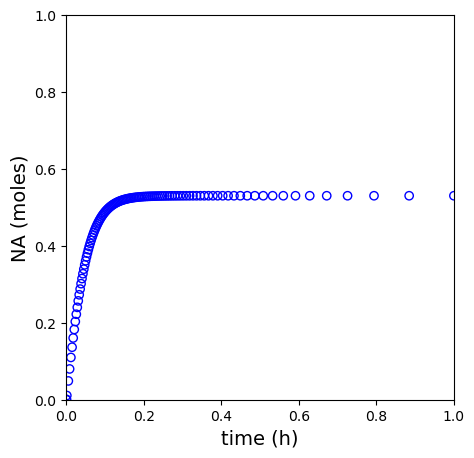

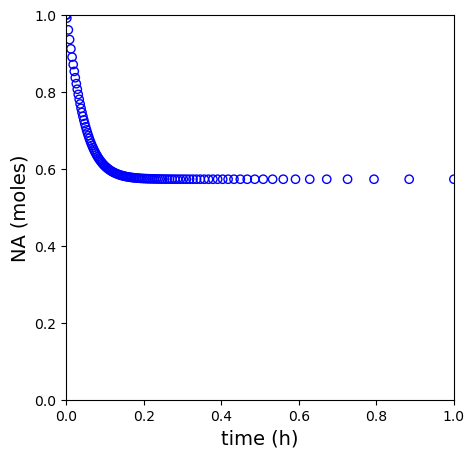

The steady state conversion in this reactor is XA = 0.573


In [4]:
def P03(t, N, p): 
    NA, NB = N
    kl, Vl, CAfl, CBfl, FAfl, FBfl, Qfl = p #parameter array, these are all "local" variables that are only defined within the function scope
    Q = Qf
    
    CA, CB = N/V
    
    FA  = CA*Q
    FB  = CB*Q
    r   = k*CA*CB
    RA  = -r
    RB  = -r
    dNAdt   = FAf - FA + RA*V
    dNBdt   = FBf - FB + RB*V
    return [dNAdt, dNBdt]

###################################################
# Defining constant parameters as globals         #
###################################################

kg   = 25.3 #1/h
Vg   = 1.24 #L
CAfg = 1.0 #mol/L
CBfg = 1.0 #mol/L
Qfg = 10 #L/h  
FAfg = CAf*Qf
FBfg = CBf*Qf

####################################################
# Store parameters in an array to pass to function #
####################################################

parameters = [kg, Vg, CAfg, CBfg, Qfg, FAfg, FBfg]

####################################################
# Define other ODE solver inputs                   #
####################################################

N0 = np.array([0.0, 0.0])
tspan = (0.0, 1.0)

####################################################
# Solve initial value problem with solve_ivp()     #
# Parameters are passed with args keyword          #
#################################################### 

sol_tCSTR = solve_ivp(P03, tspan, N0, args = (parameters, ), atol = 1e-10, rtol = 1e-10)

####################################################
# Extract significant values; workup solution      #
# We are back to global definitions here           #
####################################################

tset = sol_tCSTR.t
NA   = sol_tCSTR.y[0,:]
CA   = NA/V
FA   = CA*Qf
XA   = (FAf - FA)/FAf

####################################################
# Graphing results                                 #
####################################################

plt.figure(figsize = (5, 5))
plt.scatter(tset, NA, color = 'none', edgecolors = 'blue')
plt.xlim(0, tspan[-1])
plt.xlabel('time (h)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('NA (moles)', fontsize = 14)
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(tset, XA, color = 'none', edgecolors = 'blue')
plt.xlim(0, tspan[-1])
plt.xlabel('time (h)', fontsize = 14)
plt.ylim(0, 1)
plt.ylabel('NA (moles)', fontsize = 14)
plt.show()

######################################################
# Print the steady state conversion                  #
######################################################

print(f'The steady state conversion in this reactor is XA = {XA[-1]:0.3f}')